# HW 4-Task 3 (Air Quality Index Data + False color image)

Author: Liane Chen

GitHub link: https://github.com/lchenhub/eds220-hwk4-task3.git


## About

### Purpose
In this notebook, we use Air Quality Index (AQI) data from the US Environmental Protection Agency to visualize the impact on the AQI of the 2017 Thomas Fire in Santa Barbara County. We also will create a false color image showing the fire scar of the Thomas fire in 2017. 

### Highlights
- Fetch vector data from an online repository
- Data wrangling and exploration of with pandas
- Geospatial data wrangling with geopandas
- Creating and customizing a line plot
- Creating and customizing a false color image


### Dataset description

In this notebook we use three datasets:

1)  Air Quality Index (AQI) data from the US Environmental Protection Agency 

The first dataset contains information about EPA's index for reporting air quality.

For each pollutant an AQI value of 100 generally corresponds to an ambient air concentration that equals the level of the short-term national ambient air quality standard for protection of public health. AQI values at or below 100 are generally thought of as satisfactory. When AQI values are above 100, air quality is unhealthy: at first for certain sensitive groups of people, then for everyone as AQI values get higher.

The AQI is divided into six categories. Each category corresponds to a different level of health concern.

2) Landsat data

The second dataset is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

Information about Landsat bands from USGS:

What are the band designations for the Landsat satellites?
-Common Landsat Band Combinations

-How do I use a scale factor with Landsat Level-2 science products?

The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution (Landsat Collection in MPC). Data should be used for visualization purposes only.

3) Shapefile of fire perimeters

The third dataset is a shapefile of fire perimeters in California during 2017. The complete file can be accessed in the CA state geoportal here: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

### References to datasets

AirNow. (2021b). Air Quality Index (AQI) Basics. Retrieved from www.airnow.gov website: https://www.airnow.gov/aqi/aqi-basics/

Wikipedia Contributors. (2019, October 6). Thomas Fire. Retrieved from Wikipedia website: https://en.wikipedia.org/wiki/Thomas_Fire

California Fire Perimeters (all). (n.d.). Retrieved November 29, 2023, from gis.data.ca.gov website: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

Microsoft Planetary Computer. Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2))

In [2]:
## Importing data

import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
import matplotlib.pyplot as plt

import rioxarray as rioxr

import geopandas as gpd
from shapely.geometry import Polygon


In [5]:
## Download data

# read in files using pd.read_csv
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')

landsat = os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc') #define path
landsat = rioxr.open_rasterio(landsat) #import

fire = gpd.read_file('data/California_Fire_Perimeters/California_Fire_Perimeters_2017.shp')

In [6]:
## Explore AQ data

#look at first 5 rows of aqi_17
aqi_17.head()

#look at first 5 rows of aqi_18
aqi_18.head()

#use .info to explore data. date is an object.
aqi_17.info()
aqi_18.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326801 entries, 0 to 326800
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State Name                 326801 non-null  object
 1   county Name                326801 non-null  object
 2   State Code                 326801 non-null  int64 
 3   County Code                326801 non-null  int64 
 4   Date                       326801 non-null  object
 5   AQI                        326801 non-null  int64 
 6   Category                   326801 non-null  object
 7   Defining Parameter         326801 non-null  object
 8   Defining Site              326801 non-null  object
 9   Number of Sites Reporting  326801 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327537 entries, 0 to 327536
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 

In [7]:
## Explore landsat data

#look at table
landsat

# update column names to small caps
fire.columns = fire.columns.str.lower()

#look at first 5 rows
fire.head()

# print information about the CRS
fire.crs

# check whether the CRSs match
landsat.rio.crs == fire.crs

# see what the CRS for landsat is
landsat.rio.crs

CRS.from_epsg(32611)

In [8]:
## Update AQ data

# concatenate two dataframes
aqi = pd.concat([aqi_17, aqi_18])

# see initial column names: notice caps and spaces (difficult to work with!)
aqi.columns, '\n'

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()
aqi.columns, '\n'

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _ 
aqi.columns = aqi.columns.str.replace(' ','_')
aqi.columns, '\n'

# as a "one liner" you could achieve this column name cleaning like this:
# aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

#select only data from SB county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

#remove state_name, county_name, state_code and county_code columns 
aqi_sb.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis=1)

#use pd.to_datetime to update date column to be a datetime object from object
aqi_sb.date = pd.to_datetime(aqi_sb.date)

#update index
aqi_sb = aqi_sb.set_index("date")

#datatype (dtype) is datetime64[ns]

# rolling() is a method for pandas.series that provides rolling window calculations
# the parameter '5D' indicates we want the window to be 5 days
# This is a lazy method (think groupby), we need to specify what we want to calculate over each window
# here we add the aggregator function mean()
# this indicates we want the mean over each window
# and we get a pd.Series as ouput
aqi_sb.aqi.rolling('5D').mean()

# add mean of 5-day avg as new column with [] and .mean
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

/tmp/ipykernel_1660103/2365823.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_sb.date = pd.to_datetime(aqi_sb.date)


In [9]:
## Update landsat and fire data

# convert the fire crs to match landsat crs
fire = fire.to_crs(landsat.rio.crs)

#check that crs now matches
landsat.rio.crs == fire.crs

# select thomas fire data
thomas = fire.loc[fire['fire_name'] == "THOMAS"]

#drop the band so we can plot later
landsat = landsat.squeeze().drop('band')

<AxesSubplot:title={'center':'AQI levels in SB'}, xlabel='date'>

<Figure size 640x480 with 0 Axes>

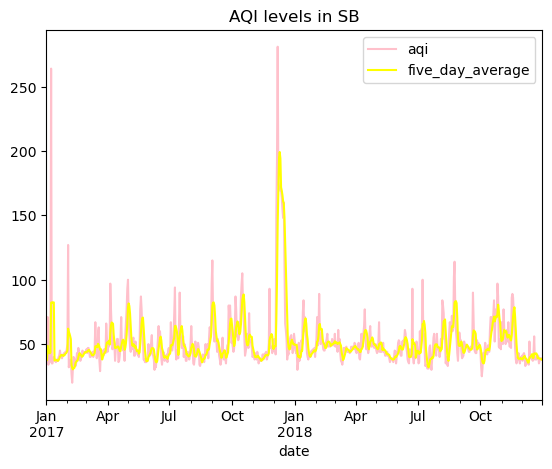

In [11]:
## Plot and create image

# plot daily AQI and 5-day avg

#initialize plot
plt.figure()

#plot with 5-day avg on top of the AQI and customize labels and colors
aqi_sb.plot(y=['aqi', 'five_day_average'], title='AQI levels in SB', color = ['pink', 'yellow'])

#The Thomas fire event in December of 2017 is visable on the plot as a high spike. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Thomas Fire in SB County')

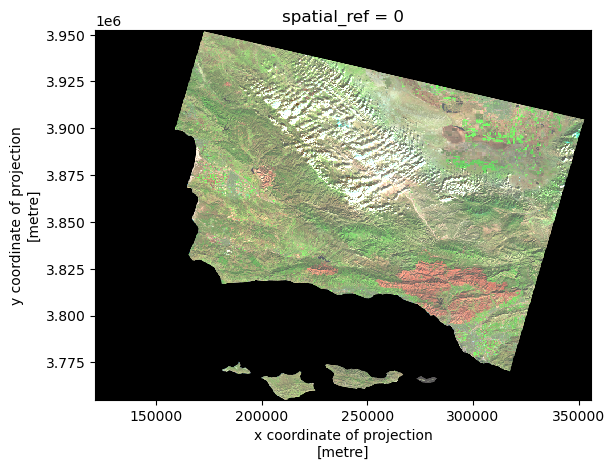

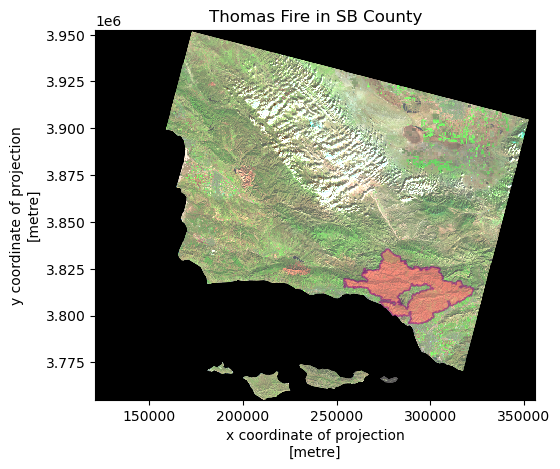

In [12]:
# Plot Thomas fire

#select red, green, blue variables, convert to a numpy.array, and then plot
landsat[['red','blue','green']].to_array().plot.imshow()

#adjust the scale used to get a true color image
landsat[['red','blue','green']].to_array().plot.imshow(robust = True)

# create false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

#convert landsat CRS to match w fire CRS
fire = fire.to_crs(landsat.rio.crs)

# plot
fig, ax = plt.subplots()

# plot Thomas fire on top of the landsat plot by plotting landsat first, then thomas
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

thomas.plot(ax=ax, color = 'salmon', alpha = 0.5, edgecolor = 'purple')

#set title name
ax.set_title('Thomas Fire in SB County', fontsize=12)